In [79]:
pip install Pillow

In [80]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from imgaug import augmenters as iaa
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import glob
import copy
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
from skimage import io, transform
from torchvision import transforms, utils

In [81]:
# mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
cd /content/drive/MyDrive/COS429_Final_Project/

/content/drive/.shortcut-targets-by-id/1ovw9re0A-fNM5W9dPWViPUskeUdZQ7j6/COS429_Final_Project


In [83]:
class_name = {}
label_names = []
for i, label in enumerate(os.listdir('BOSTON_DATA_28_TRAINVAL/train/')):
  label_names.append(label)
  class_name[label] = i
  print(label)
  

CANCEL
HAPPY
WHY
SICK
CHAT
CORRECT
THANK_YOU
FRIEND
BIG
NO
LOVE
PARTY
ALWAYS
BREAKDOWN
LIVE
FAVORITE
BORED
CLEAN
BORN
BEAUTIFUL
WHAT
CRASH
BREAK
CANNOT
NONE


In [84]:
len(label_names)

25

In [85]:
cd BOSTON_DATA_28_TRAINVAL/

/content/drive/.shortcut-targets-by-id/1ovw9re0A-fNM5W9dPWViPUskeUdZQ7j6/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL


In [86]:
# following this tutorial: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# old image
# path = '/content/drive/MyDrive/COS429_Final_Project/signs_images/train'

# new path to get static images for CNN
root_folder_name = 'BOSTON_DATA_28_TRAINVAL'
path = '/content/drive/MyDrive/COS429_Final_Project/' + root_folder_name

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = len(label_names) # change when done finetuning

# Batch size for training (change depending on how much memory you have)
batch_size = 16
input_size = 224

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
# feature_extract = False

In [87]:
def crop_center(img,cropx=112,cropy=224):
    y,x,d = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [88]:
# sampler is used to get valid indices for batches of sequences of imgs
class ImageSampler(torch.utils.data.Sampler):
    def __init__(self, end_idx, seq_length):        
        indices = []
        #print(end_idx)
        for i in range(len(end_idx)-1):
            start = end_idx[i]
            end = end_idx[i+1] - seq_length
            if (start > end): 
              break
            indices.append(torch.arange(start, end))
        indices = torch.cat(indices)
        self.indices = indices
        
    def __iter__(self):
        indices = self.indices[torch.randperm(len(self.indices))]
        return iter(indices.tolist())
    
    def __len__(self):
        return len(self.indices)

# homemade dataset to get sequences of images for LSTM 
class ImageSequenceDataset(Dataset):
    def __init__(self, image_paths, seq_length, transform, length, train):
        self.image_paths = image_paths
        self.seq_length = seq_length
        self.transform = transform
        self.length = length
        #AUG
        self.train = train 
        
    def __getitem__(self, index):
        start = index
        end = index + self.seq_length
        #print('Getting images from {} to {}'.format(start, end))
        indices = list(range(start, end))
        images = []
        #AUG
        coarsedrop = np.random.uniform(0, 0.5)
        sp = np.random.uniform()
        gc = np.random.uniform(0.5, 2)
        aug = iaa.Sequential([
                         iaa.CoarseDropout(coarsedrop, size_percent=sp), 
                         iaa.GammaContrast(gc), 
                         iaa.Fliplr(p=1.0)])
                         #iaa.AdditiveGaussianNoise(10,20)])
        #AUG
        p = np.random.uniform()
        idx = 0 
        while idx < len(indices):
            i = indices[idx]
            image_path = self.image_paths[i][0]
            try:
              image = cv2.imread(image_path)
              #image = cv2.resize(image, (input_size, input_size))
              #image = crop_center(image)
              #print(image_path)
              #if not image: 
              # print('image shape done', image_path, image.shape)
              '''face_path_arr = image_path.split('/')
              face_path_arr[5] = 'BOSTON_DATA_28_FACES_TRAINVAL'
              face_path_arr[-1] = 'face-'+face_path_arr[-1]
              face_path = "/".join(face_path_arr)
              face = cv2.imread(face_path)
              #print(face_path)
              #if not face:
              print('face shape done', image_path, face.shape)'''
            except:
              break
            #face = cv2.resize(face, (input_size // 2, input_size))
            #image = cv2.resize(image, (input_size // 2, input_size))
            #image = cv2.hconcat([image, face])
            #AUG
            if p > 0.5 and self.train:
              image = aug(image=image)
            image = Image.fromarray(image)
            if self.transform:
              image = self.transform(image)
            images.append(image)
            idx += 1
        while len(images) != 0 and len(images) < 3: 
          images.append(images[-1])
        image_stack = torch.stack(images)
        label = class_name[self.image_paths[i][0].split('/')[7]]
        print(self.image_paths[i][0].split('/')[7])
        return image_stack, label
    
    def __len__(self):
        return self.length

In [89]:
root_dir = '/content/drive/MyDrive/COS429_Final_Project/'+root_folder_name+'/train'
class_paths = [d.path for d in os.scandir(root_dir) if d.is_dir]

class_image_paths = []
end_idx = []
for c, class_path in enumerate(class_paths):
    for d in os.scandir(class_path):
        if d.is_dir:
            paths = sorted(glob.glob(os.path.join(d.path, '*.jpg')))
            #print(d.path)
            # Add class idx to paths
            paths = [(p, c) for p in paths]
            class_image_paths.extend(paths)
            end_idx.extend([len(paths)])

end_idx = [0, *end_idx]
end_idx = torch.cumsum(torch.tensor(end_idx), 0)
seq_length = 3

sampler = ImageSampler(end_idx, seq_length)
input_size = 224

# TODO: Fix transformer dimensions
transform = transforms.Compose([
        transforms.Resize((input_size)),  
        transforms.CenterCrop(input_size),                     
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageSequenceDataset(
    image_paths=class_image_paths,
    seq_length=seq_length,
    transform=transform,
    length=len(sampler), 
    #AUG
    train=True)


loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=sampler
)

dataloaders_dict_train = {x: loader for x in ['train']}

CANCEL
HAPPY
WHY
CANCEL
CHAT
CANCEL
WHY
SICK
CANCEL
SICK
SICK
SICK
SICK
WHY
CANCEL
CORRECT


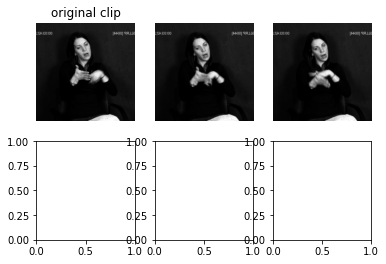

In [90]:
# Display resulting image
inputs, classes = next(iter(dataloaders_dict_train['train']))  

clip = inputs[0]
fig, axes = plt.subplots(2, seq_length)
for img_idx in range(seq_length):
    img = clip[img_idx]
    img_display = torch.transpose(img.data, 0, 2)
    img_display = torch.transpose(img_display, 0, 1)
    axes[0, img_idx].imshow(img_display)
    axes[0, img_idx].axis('off')
    axes[0, 0].set_title('original clip')
plt.show()


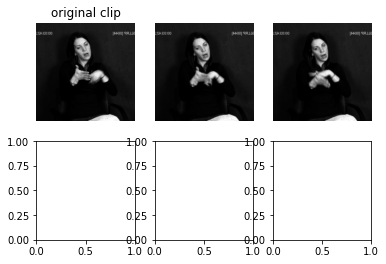

In [91]:
# change the index of inputs!!
clip = inputs[0]
fig, axes = plt.subplots(2, seq_length)
for img_idx in range(seq_length):
    img = clip[img_idx]
    img_display = torch.transpose(img.data, 0, 2)
    img_display = torch.transpose(img_display, 0, 1)
    axes[0, img_idx].imshow(img_display)
    axes[0, img_idx].axis('off')
    axes[0, 0].set_title('original clip')
plt.show()

In [92]:
root_dir = '/content/drive/MyDrive/COS429_Final_Project/'+root_folder_name+'/val'
class_paths = [d.path for d in os.scandir(root_dir) if d.is_dir]

class_image_paths = []
end_idx = []
for c, class_path in enumerate(class_paths):
    for d in os.scandir(class_path):
        if d.is_dir:
            paths = sorted(glob.glob(os.path.join(d.path, '*.jpg')))
            #print(d.path)
            # Add class idx to paths
            paths = [(p, c) for p in paths]
            class_image_paths.extend(paths)
            end_idx.extend([len(paths)])

end_idx = [0, *end_idx]
end_idx = torch.cumsum(torch.tensor(end_idx), 0)
seq_length = 3

sampler = ImageSampler(end_idx, seq_length)
input_size = 224

# TODO: Fix transformer dimensions
transform = transforms.Compose([
        transforms.Resize((input_size)),  
        transforms.CenterCrop(input_size),                     
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageSequenceDataset(
    image_paths=class_image_paths,
    seq_length=seq_length,
    transform=transform,
    length=len(sampler), 
    #AUG
    train=False)



loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=sampler
)


dataloaders_dict_val = {x: loader for x in ['val']}

SICK
SICK
WHY
FRIEND
SICK
FRIEND
WHY
FRIEND
SICK
SICK
WHY
WHY
HAPPY
WHY
CHAT
WHY


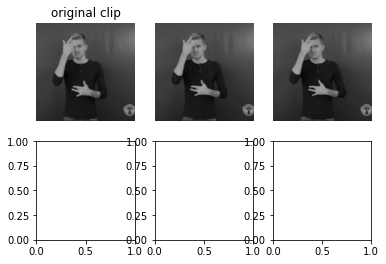

In [93]:
# Display resulting image from val
inputs, classes = next(iter(dataloaders_dict_val['val']))  

clip = inputs[0]
fig, axes = plt.subplots(2, seq_length)
for img_idx in range(seq_length):
    img = clip[img_idx]
    img_display = torch.transpose(img.data, 0, 2)
    img_display = torch.transpose(img_display, 0, 1)
    axes[0, img_idx].imshow(img_display)
    axes[0, img_idx].axis('off')
    axes[0, 0].set_title('original clip')
plt.show()

In [94]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
# freezing
feature_extract = True

In [95]:
class ResCRNN(nn.Module):
    def __init__(self, sample_size=256, sample_duration=seq_length, num_classes=num_classes,
                lstm_hidden_size=512, lstm_num_layers=1, arch="ours",
                attention=False):
        super(ResCRNN, self).__init__()
        self.sample_size = sample_size
        self.sample_duration = sample_duration
        self.num_classes = num_classes

        # network params
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.attention = attention

        # network architecture
        if arch == "resnet18":
            resnet = models.resnet18(pretrained=True)
        elif arch == "resnet34":
            resnet = models.resnet34(pretrained=True)
        elif arch == "resnet50":
            resnet = models.resnet50(pretrained=True)
        elif arch == "resnet101":
            resnet = models.resnet101(pretrained=True)
        elif arch == "resnet152":
            resnet = models.resnet152(pretrained=True)
        elif arch == "ours":
          resnet = torch.load('/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/model.npz', map_location='cpu')
          set_parameter_requires_grad(resnet, feature_extracting=True)
        # delete the last fc layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        in_features = list(resnet.children())[-1][1].in_features
        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_num_layers,
            batch_first=True,
        )
        if self.attention:
            self.attn_block = LSTMAttentionBlock(hidden_size=self.lstm_hidden_size)
        self.fc1 = nn.Linear(self.lstm_hidden_size, self.num_classes)

    def forward(self, x):
        # CNN
        cnn_embed_seq = []
        # x: (batch_size, t, channel, h, w)
        for t in range(x.size(1)):
            # with torch.no_grad():
            out = self.resnet(x[:, t, :, :, :])
            # print(out.shape)
            out = out.view(out.size(0), -1)
            cnn_embed_seq.append(out)

        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0)
        # print(cnn_embed_seq.shape)
        # batch first
        cnn_embed_seq = cnn_embed_seq.transpose_(0, 1)

        # LSTM
        # use faster code paths
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(cnn_embed_seq, None)
        # MLP
        if self.attention:
            out = self.fc1(self.attn_block(out))
        else:
            # out: (batch, seq, feature), choose the last time step
            out = self.fc1(out[:, -1, :])

        return out

In [96]:
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_epoch(model, criterion, optimizer, dataloader, device, epoch, logger, log_interval, writer):
    model.train()
    losses = []
    all_label = []
    all_pred = []

    for batch_idx, data in enumerate(dataloader):
        # get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        if isinstance(outputs, list):
            outputs = outputs[0]

        # compute the loss
        #print('labels into loss function: ', labels)
        loss = criterion(outputs, labels.squeeze())
        losses.append(loss.item())

        # compute the accuracy
        prediction = torch.max(outputs, 1)[1]
        all_label.extend(labels.squeeze())
        all_pred.extend(prediction)
        score = accuracy_score(labels.squeeze().cpu().data.squeeze().numpy(), prediction.cpu().data.squeeze().numpy())

        # backward & optimize
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            print("epoch {:3d} | iteration {:5d} | Loss {:.6f} | Acc {:.2f}%".format(epoch+1, batch_idx+1, loss.item(), score*100))
            logger.info("epoch {:3d} | iteration {:5d} | Loss {:.6f} | Acc {:.2f}%".format(epoch+1, batch_idx+1, loss.item(), score*100))

    # Compute the average loss & accuracy
    training_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    training_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())
    # Log
    writer.add_scalars('Loss', {'train': training_loss}, epoch+1)
    writer.add_scalars('Accuracy', {'train': training_acc}, epoch+1)
    logger.info("Average Training Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, training_loss, training_acc*100))
    print("Average Training Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, training_loss, training_acc*100))
    return training_loss, training_acc

In [97]:
def val_epoch(model, criterion, dataloader, device, epoch, logger, writer):
    model.eval()
    losses = []
    all_label = []
    all_pred = []

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            # get the inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)
            # forward
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[0]
            # compute the loss
            #print('labels into loss function: ', labels)
            #print(outputs.size(0))
            if outputs.size(0) < 3: 
              print('break')
              break
            #print(labels.squeeze().size(0))
            loss = criterion(outputs, labels.squeeze())
            losses.append(loss.item())
            # collect labels & prediction
            prediction = torch.max(outputs, 1)[1]
            all_label.extend(labels.squeeze())
            all_pred.extend(prediction)
    # Compute the average loss & accuracy
    validation_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    validation_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())
    # Log
    writer.add_scalars('Loss', {'validation': validation_loss}, epoch+1)
    writer.add_scalars('Accuracy', {'validation': validation_acc}, epoch+1)
    print("Average Validation Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, validation_loss, validation_acc*100))
    logger.info("Average Validation Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, validation_loss, validation_acc*100))
    return validation_loss, validation_acc

Logging to file...
This should go to both console and file
######################Training Started######################


Epoch:  0
training model


epoch   1 | iteration    20 | Loss 2.783863 | Acc 31.25%


epoch   1 | iteration    20 | Loss 2.783863 | Acc 31.25%


epoch   1 | iteration    40 | Loss 2.130571 | Acc 68.75%


epoch   1 | iteration    40 | Loss 2.130571 | Acc 68.75%


epoch   1 | iteration    60 | Loss 1.716552 | Acc 68.75%


epoch   1 | iteration    60 | Loss 1.716552 | Acc 68.75%


epoch   1 | iteration    80 | Loss 1.270905 | Acc 87.50%


epoch   1 | iteration    80 | Loss 1.270905 | Acc 87.50%


epoch   1 | iteration   100 | Loss 1.073087 | Acc 87.50%


epoch   1 | iteration   100 | Loss 1.073087 | Acc 87.50%


Average Training Loss of Epoch 1: 2.126344 | Acc: 53.22%


Average Training Loss of Epoch 1: 2.126344 | Acc: 53.22%
validating model


Average Validation Loss of Epoch 1: 1.040123 | Acc: 78.10%


Average Validation Loss of Epoch 1: 1.040123 | Acc: 78.10%


####################Epoch 1 Model Saved#####################


Epoch:  1
training model


epoch   2 | iteration    20 | Loss 1.100067 | Acc 68.75%


epoch   2 | iteration    20 | Loss 1.100067 | Acc 68.75%


epoch   2 | iteration    40 | Loss 1.243532 | Acc 68.75%


epoch   2 | iteration    40 | Loss 1.243532 | Acc 68.75%


epoch   2 | iteration    60 | Loss 0.813231 | Acc 87.50%


epoch   2 | iteration    60 | Loss 0.813231 | Acc 87.50%


epoch   2 | iteration    80 | Loss 0.675731 | Acc 81.25%


epoch   2 | iteration    80 | Loss 0.675731 | Acc 81.25%


epoch   2 | iteration   100 | Loss 0.660442 | Acc 75.00%


epoch   2 | iteration   100 | Loss 0.660442 | Acc 75.00%


Average Training Loss of Epoch 2: 0.874226 | Acc: 77.91%


Average Training Loss of Epoch 2: 0.874226 | Acc: 77.91%
validating model


Average Validation Loss of Epoch 2: 0.509861 | Acc: 88.43%


Average Validation Loss of Epoch 2: 0.509861 | Acc: 88.43%


####################Epoch 2 Model Saved#####################


Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.805253 | Acc 81.25%


epoch   3 | iteration    20 | Loss 0.805253 | Acc 81.25%


epoch   3 | iteration    40 | Loss 0.986561 | Acc 68.75%


epoch   3 | iteration    40 | Loss 0.986561 | Acc 68.75%


epoch   3 | iteration    60 | Loss 0.797411 | Acc 68.75%


epoch   3 | iteration    60 | Loss 0.797411 | Acc 68.75%


epoch   3 | iteration    80 | Loss 0.564750 | Acc 87.50%


epoch   3 | iteration    80 | Loss 0.564750 | Acc 87.50%


epoch   3 | iteration   100 | Loss 0.367614 | Acc 93.75%


epoch   3 | iteration   100 | Loss 0.367614 | Acc 93.75%


Average Training Loss of Epoch 3: 0.625295 | Acc: 85.44%


Average Training Loss of Epoch 3: 0.625295 | Acc: 85.44%
validating model


Average Validation Loss of Epoch 3: 0.381697 | Acc: 92.07%


Average Validation Loss of Epoch 3: 0.381697 | Acc: 92.07%


####################Epoch 3 Model Saved#####################


Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.231390 | Acc 100.00%


epoch   4 | iteration    20 | Loss 0.231390 | Acc 100.00%


epoch   4 | iteration    40 | Loss 0.332087 | Acc 93.75%


epoch   4 | iteration    40 | Loss 0.332087 | Acc 93.75%


epoch   4 | iteration    60 | Loss 0.178444 | Acc 100.00%


epoch   4 | iteration    60 | Loss 0.178444 | Acc 100.00%


epoch   4 | iteration    80 | Loss 0.292733 | Acc 93.75%


epoch   4 | iteration    80 | Loss 0.292733 | Acc 93.75%


epoch   4 | iteration   100 | Loss 0.432228 | Acc 87.50%


epoch   4 | iteration   100 | Loss 0.432228 | Acc 87.50%


Average Training Loss of Epoch 4: 0.508676 | Acc: 88.47%


Average Training Loss of Epoch 4: 0.508676 | Acc: 88.47%
validating model


Average Validation Loss of Epoch 4: 0.321360 | Acc: 93.55%


Average Validation Loss of Epoch 4: 0.321360 | Acc: 93.55%


####################Epoch 4 Model Saved#####################


Epoch:  4
training model


epoch   5 | iteration    20 | Loss 0.624004 | Acc 87.50%


epoch   5 | iteration    20 | Loss 0.624004 | Acc 87.50%


epoch   5 | iteration    40 | Loss 0.940246 | Acc 68.75%


epoch   5 | iteration    40 | Loss 0.940246 | Acc 68.75%


epoch   5 | iteration    60 | Loss 0.410226 | Acc 87.50%


epoch   5 | iteration    60 | Loss 0.410226 | Acc 87.50%


epoch   5 | iteration    80 | Loss 0.472291 | Acc 87.50%


epoch   5 | iteration    80 | Loss 0.472291 | Acc 87.50%


epoch   5 | iteration   100 | Loss 0.595692 | Acc 81.25%


epoch   5 | iteration   100 | Loss 0.595692 | Acc 81.25%


Average Training Loss of Epoch 5: 0.432696 | Acc: 90.11%


Average Training Loss of Epoch 5: 0.432696 | Acc: 90.11%
validating model


Average Validation Loss of Epoch 5: 0.280299 | Acc: 95.62%


Average Validation Loss of Epoch 5: 0.280299 | Acc: 95.62%


####################Epoch 5 Model Saved#####################


Epoch:  5
training model


epoch   6 | iteration    20 | Loss 0.367179 | Acc 87.50%


epoch   6 | iteration    20 | Loss 0.367179 | Acc 87.50%


epoch   6 | iteration    40 | Loss 0.434424 | Acc 93.75%


epoch   6 | iteration    40 | Loss 0.434424 | Acc 93.75%


epoch   6 | iteration    60 | Loss 0.587721 | Acc 87.50%


epoch   6 | iteration    60 | Loss 0.587721 | Acc 87.50%


epoch   6 | iteration    80 | Loss 0.439480 | Acc 87.50%


epoch   6 | iteration    80 | Loss 0.439480 | Acc 87.50%


epoch   6 | iteration   100 | Loss 0.231462 | Acc 100.00%


epoch   6 | iteration   100 | Loss 0.231462 | Acc 100.00%


Average Training Loss of Epoch 6: 0.373178 | Acc: 91.50%


Average Training Loss of Epoch 6: 0.373178 | Acc: 91.50%
validating model


Average Validation Loss of Epoch 6: 0.303280 | Acc: 92.31%


Average Validation Loss of Epoch 6: 0.303280 | Acc: 92.31%


####################Epoch 6 Model Saved#####################


Epoch:  6
training model


epoch   7 | iteration    20 | Loss 0.241216 | Acc 100.00%


epoch   7 | iteration    20 | Loss 0.241216 | Acc 100.00%


epoch   7 | iteration    40 | Loss 0.402542 | Acc 93.75%


epoch   7 | iteration    40 | Loss 0.402542 | Acc 93.75%


epoch   7 | iteration    60 | Loss 0.611884 | Acc 81.25%


epoch   7 | iteration    60 | Loss 0.611884 | Acc 81.25%


epoch   7 | iteration    80 | Loss 0.230861 | Acc 100.00%


epoch   7 | iteration    80 | Loss 0.230861 | Acc 100.00%


epoch   7 | iteration   100 | Loss 0.322300 | Acc 87.50%


epoch   7 | iteration   100 | Loss 0.322300 | Acc 87.50%


Average Training Loss of Epoch 7: 0.347342 | Acc: 91.93%


Average Training Loss of Epoch 7: 0.347342 | Acc: 91.93%
validating model


Average Validation Loss of Epoch 7: 0.272367 | Acc: 93.88%


Average Validation Loss of Epoch 7: 0.272367 | Acc: 93.88%


####################Epoch 7 Model Saved#####################


Epoch:  7
training model


epoch   8 | iteration    20 | Loss 0.332119 | Acc 93.75%


epoch   8 | iteration    20 | Loss 0.332119 | Acc 93.75%


epoch   8 | iteration    40 | Loss 0.251122 | Acc 100.00%


epoch   8 | iteration    40 | Loss 0.251122 | Acc 100.00%


epoch   8 | iteration    60 | Loss 0.257753 | Acc 93.75%


epoch   8 | iteration    60 | Loss 0.257753 | Acc 93.75%


epoch   8 | iteration    80 | Loss 0.370151 | Acc 93.75%


epoch   8 | iteration    80 | Loss 0.370151 | Acc 93.75%


epoch   8 | iteration   100 | Loss 0.294864 | Acc 93.75%


epoch   8 | iteration   100 | Loss 0.294864 | Acc 93.75%


Average Training Loss of Epoch 8: 0.352883 | Acc: 91.87%


Average Training Loss of Epoch 8: 0.352883 | Acc: 91.87%
validating model


Average Validation Loss of Epoch 8: 0.249245 | Acc: 95.21%


Average Validation Loss of Epoch 8: 0.249245 | Acc: 95.21%


####################Epoch 8 Model Saved#####################


Epoch:  8
training model


epoch   9 | iteration    20 | Loss 0.336499 | Acc 100.00%


epoch   9 | iteration    20 | Loss 0.336499 | Acc 100.00%


epoch   9 | iteration    40 | Loss 0.613817 | Acc 81.25%


epoch   9 | iteration    40 | Loss 0.613817 | Acc 81.25%


epoch   9 | iteration    60 | Loss 0.183477 | Acc 100.00%


epoch   9 | iteration    60 | Loss 0.183477 | Acc 100.00%


epoch   9 | iteration    80 | Loss 0.545813 | Acc 81.25%


epoch   9 | iteration    80 | Loss 0.545813 | Acc 81.25%


epoch   9 | iteration   100 | Loss 0.133369 | Acc 100.00%


epoch   9 | iteration   100 | Loss 0.133369 | Acc 100.00%


Average Training Loss of Epoch 9: 0.312826 | Acc: 93.33%


Average Training Loss of Epoch 9: 0.312826 | Acc: 93.33%
validating model


Average Validation Loss of Epoch 9: 0.258665 | Acc: 94.21%


Average Validation Loss of Epoch 9: 0.258665 | Acc: 94.21%


####################Epoch 9 Model Saved#####################


Epoch:  9
training model


epoch  10 | iteration    20 | Loss 0.407811 | Acc 87.50%


epoch  10 | iteration    20 | Loss 0.407811 | Acc 87.50%


epoch  10 | iteration    40 | Loss 0.166398 | Acc 100.00%


epoch  10 | iteration    40 | Loss 0.166398 | Acc 100.00%


epoch  10 | iteration    60 | Loss 0.237273 | Acc 100.00%


epoch  10 | iteration    60 | Loss 0.237273 | Acc 100.00%


epoch  10 | iteration    80 | Loss 0.231364 | Acc 93.75%


epoch  10 | iteration    80 | Loss 0.231364 | Acc 93.75%


epoch  10 | iteration   100 | Loss 0.213162 | Acc 100.00%


epoch  10 | iteration   100 | Loss 0.213162 | Acc 100.00%


Average Training Loss of Epoch 10: 0.315060 | Acc: 92.84%


Average Training Loss of Epoch 10: 0.315060 | Acc: 92.84%
validating model


Average Validation Loss of Epoch 10: 0.235391 | Acc: 94.88%


Average Validation Loss of Epoch 10: 0.235391 | Acc: 94.88%


####################Epoch 10 Model Saved####################


Epoch:  10
training model


epoch  11 | iteration    20 | Loss 0.104615 | Acc 100.00%


epoch  11 | iteration    20 | Loss 0.104615 | Acc 100.00%


epoch  11 | iteration    40 | Loss 0.363520 | Acc 93.75%


epoch  11 | iteration    40 | Loss 0.363520 | Acc 93.75%


epoch  11 | iteration    60 | Loss 0.295860 | Acc 93.75%


epoch  11 | iteration    60 | Loss 0.295860 | Acc 93.75%


epoch  11 | iteration    80 | Loss 0.668752 | Acc 75.00%


epoch  11 | iteration    80 | Loss 0.668752 | Acc 75.00%


epoch  11 | iteration   100 | Loss 0.355529 | Acc 87.50%


epoch  11 | iteration   100 | Loss 0.355529 | Acc 87.50%


Average Training Loss of Epoch 11: 0.282253 | Acc: 93.57%


Average Training Loss of Epoch 11: 0.282253 | Acc: 93.57%
validating model


Average Validation Loss of Epoch 11: 0.257044 | Acc: 94.55%


Average Validation Loss of Epoch 11: 0.257044 | Acc: 94.55%


####################Epoch 11 Model Saved####################


Epoch:  11
training model


epoch  12 | iteration    20 | Loss 0.172403 | Acc 100.00%


epoch  12 | iteration    20 | Loss 0.172403 | Acc 100.00%


epoch  12 | iteration    40 | Loss 0.159562 | Acc 100.00%


epoch  12 | iteration    40 | Loss 0.159562 | Acc 100.00%


epoch  12 | iteration    60 | Loss 0.329847 | Acc 87.50%


epoch  12 | iteration    60 | Loss 0.329847 | Acc 87.50%


epoch  12 | iteration    80 | Loss 0.248233 | Acc 93.75%


epoch  12 | iteration    80 | Loss 0.248233 | Acc 93.75%


epoch  12 | iteration   100 | Loss 0.367626 | Acc 87.50%


epoch  12 | iteration   100 | Loss 0.367626 | Acc 87.50%


Average Training Loss of Epoch 12: 0.274936 | Acc: 93.45%


Average Training Loss of Epoch 12: 0.274936 | Acc: 93.45%
validating model


Average Validation Loss of Epoch 12: 0.241613 | Acc: 95.45%


Average Validation Loss of Epoch 12: 0.241613 | Acc: 95.45%


####################Epoch 12 Model Saved####################


Epoch:  12
training model


epoch  13 | iteration    20 | Loss 0.452922 | Acc 93.75%


epoch  13 | iteration    20 | Loss 0.452922 | Acc 93.75%


epoch  13 | iteration    40 | Loss 0.310694 | Acc 100.00%


epoch  13 | iteration    40 | Loss 0.310694 | Acc 100.00%


epoch  13 | iteration    60 | Loss 0.108039 | Acc 100.00%


epoch  13 | iteration    60 | Loss 0.108039 | Acc 100.00%


epoch  13 | iteration    80 | Loss 0.213173 | Acc 93.75%


epoch  13 | iteration    80 | Loss 0.213173 | Acc 93.75%


epoch  13 | iteration   100 | Loss 0.398944 | Acc 87.50%


epoch  13 | iteration   100 | Loss 0.398944 | Acc 87.50%


Average Training Loss of Epoch 13: 0.256046 | Acc: 94.60%


Average Training Loss of Epoch 13: 0.256046 | Acc: 94.60%
validating model


Average Validation Loss of Epoch 13: 0.242964 | Acc: 93.88%


Average Validation Loss of Epoch 13: 0.242964 | Acc: 93.88%


####################Epoch 13 Model Saved####################


Epoch:  13
training model


epoch  14 | iteration    20 | Loss 0.569591 | Acc 81.25%


epoch  14 | iteration    20 | Loss 0.569591 | Acc 81.25%


epoch  14 | iteration    40 | Loss 0.315330 | Acc 93.75%


epoch  14 | iteration    40 | Loss 0.315330 | Acc 93.75%


epoch  14 | iteration    60 | Loss 0.128676 | Acc 100.00%


epoch  14 | iteration    60 | Loss 0.128676 | Acc 100.00%


epoch  14 | iteration    80 | Loss 0.219007 | Acc 93.75%


epoch  14 | iteration    80 | Loss 0.219007 | Acc 93.75%


epoch  14 | iteration   100 | Loss 0.278690 | Acc 87.50%


epoch  14 | iteration   100 | Loss 0.278690 | Acc 87.50%


Average Training Loss of Epoch 14: 0.261474 | Acc: 94.48%


Average Training Loss of Epoch 14: 0.261474 | Acc: 94.48%
validating model


Average Validation Loss of Epoch 14: 0.218360 | Acc: 95.29%


Average Validation Loss of Epoch 14: 0.218360 | Acc: 95.29%


####################Epoch 14 Model Saved####################


Epoch:  14
training model


epoch  15 | iteration    20 | Loss 0.103838 | Acc 100.00%


epoch  15 | iteration    20 | Loss 0.103838 | Acc 100.00%


epoch  15 | iteration    40 | Loss 0.166579 | Acc 100.00%


epoch  15 | iteration    40 | Loss 0.166579 | Acc 100.00%


epoch  15 | iteration    60 | Loss 0.144742 | Acc 93.75%


epoch  15 | iteration    60 | Loss 0.144742 | Acc 93.75%


epoch  15 | iteration    80 | Loss 0.110821 | Acc 100.00%


epoch  15 | iteration    80 | Loss 0.110821 | Acc 100.00%


epoch  15 | iteration   100 | Loss 0.152495 | Acc 100.00%


epoch  15 | iteration   100 | Loss 0.152495 | Acc 100.00%


Average Training Loss of Epoch 15: 0.268685 | Acc: 94.60%


Average Training Loss of Epoch 15: 0.268685 | Acc: 94.60%
validating model


Average Validation Loss of Epoch 15: 0.240031 | Acc: 94.79%


Average Validation Loss of Epoch 15: 0.240031 | Acc: 94.79%


####################Epoch 15 Model Saved####################
#####################Training Finished######################


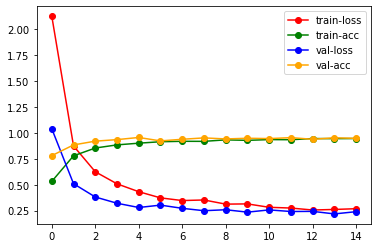

In [ ]:
import os
import sys
from datetime import datetime
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
'''
from models.ConvLSTM import CRNN, ResCRNN
from dataset import CSL_Isolated
from train import train_epoch
from validation import val_epoch
'''

# Path setting
model_path = '/content/drive/MyDrive/COS429_Final_Project/'+root_folder_name+'/cnnlstm_models'
log_path = '/content/drive/MyDrive/COS429_Final_Project/'+root_folder_name+'/log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log'.format(datetime.now())
sum_path = '/content/drive/MyDrive/COS429_Final_Project/'+root_folder_name+'/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now())

# Log to file & tensorboard writer
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('SLR')
logger.info('Logging to file...')
logger.error('This should go to both console and file')
writer = SummaryWriter(sum_path)

# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparams
epochs = 15
batch_size = batch_size #3
learning_rate = 7.618935788137979e-05
weight_decay = 0.02587591092706272
log_interval = 20
sample_size = input_size #224
sample_duration = seq_length # 3
num_classes = num_classes # 25
lstm_hidden_size = 512
lstm_num_layers = 1
attention = False
model_count = 5
# Train with Conv+LSTM
if __name__ == '__main__':
    # Load data
    train_loader = dataloaders_dict_train['train']
    val_loader = dataloaders_dict_val['val']
    # Create model
    #model = CRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
    #             lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers).to(device)
    model = ResCRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
                lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers, attention=attention).to(device)
    # Run the model parallelly
    if torch.cuda.device_count() > 1:
        logger.info("Using {} GPUs".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)
    # Create loss criterion & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Start training
    logger.info("Training Started".center(60, '#'))
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        # Train the model
        print('training model')
        training_loss, training_acc = train_epoch(model, criterion, optimizer, train_loader, device, epoch, logger, log_interval, writer)
        train_loss.append(training_loss)
        train_acc.append(training_acc)

        # Validate the model
        print('validating model')
        valid_loss, valid_acc = val_epoch(model, criterion, val_loader, device, epoch, logger, writer)
        val_loss.append(valid_loss)
        val_acc.append(valid_acc)

        # Save model
        torch.save(model.state_dict(), os.path.join(model_path, "slr_convlstm_epoch{:03d}.pth".format(epoch+1)))
        logger.info("Epoch {} Model Saved".format(epoch+1).center(60, '#'))
        writer.add_scalar('Loss/train', training_loss, epoch)
        writer.add_scalar('Loss/test', valid_loss, epoch)
        writer.add_scalar('Accuracy/train', valid_loss, epoch)
        writer.add_scalar('Accuracy/test', valid_acc, epoch)

    logger.info("Training Finished".center(60, '#'))

    plt.plot(train_loss, '-o', color='red', label='train-loss')
    plt.plot(train_acc, '-o', color='green', label='train-acc')
    plt.plot(val_loss, '-o', color='blue', label='val-loss')
    plt.plot(val_acc, '-o', color='orange', label='val-acc')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/COS429_Final_Project/'+ root_folder_name + '/plot/model' + str(model_count) + '.png')

In [ ]:
max_count = 20
def hyperparamsearch():
  for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
  logh_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/logh/params_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
  sumh_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())
  # Log to file & tensorboard writer
  logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(logh_path), logging.StreamHandler()])
  logger = logging.getLogger('SLR')
  logger.info('Logging to file...')
  logger.error('This should go to both console and file')
  writer = SummaryWriter(sumh_path)
  epochs = 3
  logger.info("Hyper Params Started".center(60, '#'))
  for count in range(max_count):
    wd = 10**np.random.uniform(-3, 2)
    lr = 10**np.random.uniform(-3, -5)
    logger.info("lr {} wd {}".format(lr, wd))
    # init model 
    model = ResCRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
              lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers, attention=attention).to(device)
    # Run the model parallelly
    if torch.cuda.device_count() > 1:
        logger.info("Using {} GPUs".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)
    # Create loss criterion & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Start training
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        # Train the model
        print('training model')
        training_loss, training_acc = train_epoch(model, criterion, optimizer, train_loader, device, epoch, logger, log_interval, writer)
        train_loss.append(training_loss)
        train_acc.append(training_acc)
        
        # Validate the model
        print('validating model')
        valid_loss, valid_acc =val_epoch(model, criterion, val_loader, device, epoch, logger, writer)
        val_loss.append(valid_loss)
        val_acc.append(valid_acc)

        # Save model
        #torch.save(model.state_dict(), os.path.join(model_path, "slr_hyperparam_epoch{:03d}.pth".format(epoch+1)))
        logger.info("Epoch {} Model Saved".format(epoch+1).center(60, '#'))
    plt.clf()
    plt.title('Train-Val Accuracy and Loss')
    plt.plot(train_loss, '-o', color='red')
    plt.plot(train_acc, '-o', color='green')
    plt.plot(val_loss, '-o', color='blue')
    plt.plot(val_acc, '-o', color='orange')
    plt.savefig('/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/plot/' + 'hyperparam-lr' + str(lr) + 'wd' + str(wd) + '.png')

  logger.info("HyperParams Finished".center(60, '#'))


In [ ]:
hyperparamsearch()